In [1]:
### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 1) make classification data and get it ready 

In [2]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples=1000

# create circles
X, y =make_circles(n_samples,
                  noise=0.035,
                  random_state=29)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
X[:5],y[:5]

(array([[-0.68128613, -0.46337946],
        [ 0.78336133, -0.32870458],
        [-0.67561375, -0.42003465],
        [-0.61874578,  0.56369272],
        [ 0.3140375 ,  0.78600705]]),
 array([1, 1, 1, 1, 1]))

In [4]:
# make dataframe of circle data
circles=pd.DataFrame({"X1":X[:,0],
                     "X2":X[:,1],
                     "label":y
                     })
circles.head()

,X1,X2,label
0,-0.681286,-0.463379,1
1,0.783361,-0.328705,1
2,-0.675614,-0.420035,1
3,-0.618746,0.563693,1
4,0.314038,0.786007,1


In [5]:
circles["label"].value_counts()

label
1    500
0    500
Name: count, dtype: int64

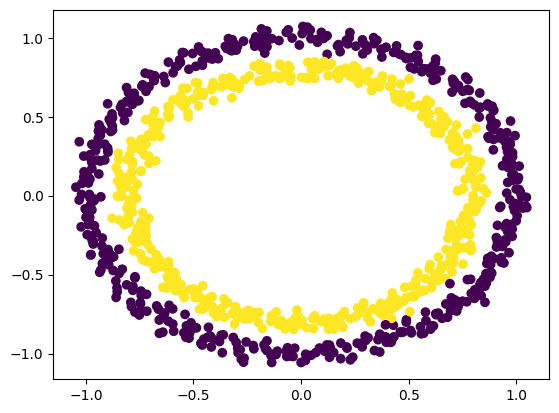

In [6]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],y=X[:,1],c=y)

### 1] input and output shape

In [7]:
X.shape,y.shape

((1000, 2), (1000,))

### 2] turn data into tensors and create train and test splits

In [8]:
import torch 
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

X[:5],y[:5]

(tensor([[-0.6813, -0.4634],
         [ 0.7834, -0.3287],
         [-0.6756, -0.4200],
         [-0.6187,  0.5637],
         [ 0.3140,  0.7860]]),
 tensor([1., 1., 1., 1., 1.]))

In [9]:
#split data into train and test
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=29)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2) Building a model

In [10]:
from torch import nn

device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
# 1. construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 2. create 2 nn.Linear layers capable of handling X and Y input and output shapes
        self.layer1=nn.Linear(in_features=2,out_features=5)
        self.layer2=nn.Linear(in_features=5,out_features=1)
        
        # 3. define a forward method containing the forward pass 
    def forward(self, x):
        return self.layer_2()
    
# 4. create an instance of the moedl and send it to target device
model_0=CircleModelV0().to(device)

In [12]:
# replicate CircleModeV0 with nn.Sequential
model_0=nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
# make prediction with model
untrained_preds=model_0(X_test.to(device))

print(len(untrained_preds),untrained_preds.shape)
print(len(y_test),y_test.shape)
print(untrained_preds[:10])
print(y_test[:10])

200 torch.Size([200, 1])
200 torch.Size([200])
tensor([[ 0.1413],
        [-0.0962],
        [-0.2569],
        [-0.1802],
        [-0.1146],
        [-0.3516],
        [-0.1862],
        [-0.3100],
        [ 0.0017],
        [-0.3725]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([0., 1., 1., 0., 1., 0., 0., 0., 1., 0.])


## 1] setup loss function and optimizer

In [14]:
# loss_fn=nn.BCELoss() # no built in sigmoid
loss_fn=nn.BCEWithLogitsLoss() # built in sigmoid

optimizer=torch.optim.SGD(params=model_0.parameters(),
                          lr=0.01)

In [15]:
def accuracy_fn(y_true, y_pred):
        correct=torch.eq(y_true, y_pred).sum().item() # torch.eq calculates where two tensors are equal
        return (correct / len(y_pred))

## 3) train model

### 1] going from raw moedl outputs to predicted labels (logits -> prediction probabilities -> pediction labels)

In [16]:
y_logits=model_0(X_test.to(device))
y_logits[:5]

tensor([[ 0.1413],
        [-0.0962],
        [-0.2569],
        [-0.1802],
        [-0.1146]], device='cuda:0', grad_fn=<SliceBackward0>)

In [17]:
y_pred_probs=torch.sigmoid(y_logits)
y_pred_probs[:5]

tensor([[0.5353],
        [0.4760],
        [0.4361],
        [0.4551],
        [0.4714]], device='cuda:0', grad_fn=<SliceBackward0>)

In [18]:
y_preds=torch.round(y_pred_probs)

y_pred_labels=torch.round(torch.round(model_0(X_test.to(device))))

print(torch.eq(y_preds.squeeze(),y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([False,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True, False,  True, False, False,  True,  True,  True, False,
         True,  True,  True, False, False, False,  True,  True, False,  True,
        False,  True,  True, False,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True, False,  True,  True, False,  True,  True,
        False,  True,  True,  True, False,  True, False, False,  True,  True,
        False,  True, False,  True,  True,  True, False,  True, False,  True,
        False,  True,  True,  True,  True, False,  True, False,  True,  True,
         True, False, False, False,  True, False,  True,  True, False, False,
         True,  True,  True,  True, False, False,  True, False,  True,  True,
         True,  True,  True, False,  True,  True, False,  True,  True,  True,
        False,  True, False, False, False,  True,  True, False, False,  True,
         True,  True, False, False, False, False,  True, False, 

tensor([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
        0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1.,
        0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [19]:
y_test[:5]

tensor([0., 1., 1., 0., 1.])

## 2] building a training and testing loop

In [20]:
torch.manual_seed(42)

epochs=500

X_train=X_train.to(device)
y_train=y_train.to(device)
X_test=X_test.to(device)
y_test=y_test.to(device)

for epoch in range(epochs):
    
    model_0.train()
    
    y_logits=model_0(X_train).squeeze() # sqeeze to remove extra dimension
    y_pred=torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> perd labels
    
    loss=loss_fn(y_logits,y_train) # if we have created loss_fn with nn.BCELoss,
    #                                         we haev to pass torch.sigmoid(y_logirs) istead of y_logits
    acc=accuracy_fn(y_true=y_train,
                   y_pred=y_pred)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model_0.eval()
    with torch.inference_mode():
        test_logits=model_0(X_test).squeeze()
        test_preds=torch.round(torch.sigmoid(test_logits))
        
        test_loss=loss_fn(test_logits,y_test)
        test_acc=accuracy_fn(y_true=y_test,
                            y_pred=test_preds)
    if epoch%25==0:
        print(epoch)
        print(loss,acc)
        print(test_loss,test_acc)
        print("\n")

0
tensor(0.6996, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 0.47875
tensor(0.6944, device='cuda:0') 0.475


25
tensor(0.6991, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 0.48125
tensor(0.6941, device='cuda:0') 0.48


50
tensor(0.6986, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 0.48
tensor(0.6938, device='cuda:0') 0.49


75
tensor(0.6982, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 0.48
tensor(0.6936, device='cuda:0') 0.5


100
tensor(0.6978, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 0.47875
tensor(0.6935, device='cuda:0') 0.51


125
tensor(0.6975, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 0.4775
tensor(0.6933, device='cuda:0') 0.515


150
tensor(0.6971, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 0.47875
tensor(0.6932, device='cuda:0') 0.515


175
tensor(0.6969, device='cuda:0',
 

## 4) make predictions and evaluate teh model

In [21]:
import requests
from pathlib import Path

if Path("helper_functoins.py").is_file():
    print("already exist")
else:
    request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py","wb") as f:
        f.write(request.content)

In [22]:
from helper_functions import plot_decision_boundary, plot_predictions

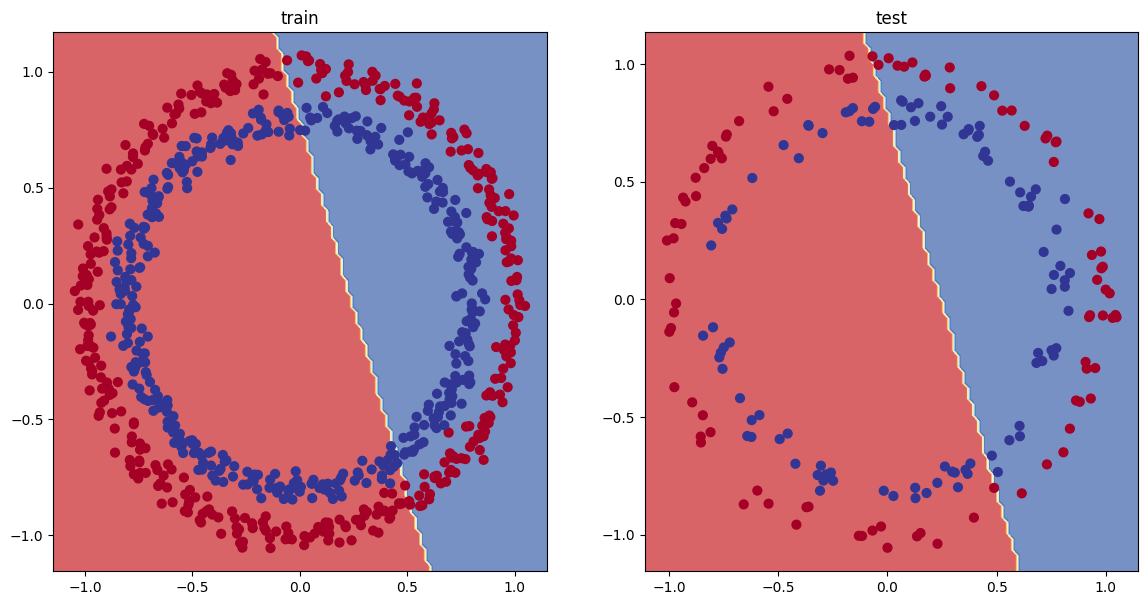

In [23]:
plt.figure(figsize=(14,7))

plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_0,X_train,y_train)

plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_0,X_test,y_test)

## 5) improving the model

In [24]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1=nn.Linear(in_features=2,out_features=10)
        self.layer2=nn.Linear(in_features=10,out_features=10)
        self.layer3=nn.Linear(in_features=10,out_features=1)
        
    def forward(self, x):
        return self.layer3(self.layer2(self.layer1(x)))
model_1=CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [25]:
loss_fn=nn.BCEWithLogitsLoss()

optimizer=torch.optim.SGD(params=model_1.parameters(),
                         lr=0.01)

In [26]:
torch.manual_seed(42)

epochs=1000

X_train=X_train.to(device)
y_train=y_train.to(device)
X_test=X_test.to(device)
y_test=y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    
    y_logits=model_1(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logits))
    
    loss=loss_fn(y_logits,y_train)
    acc=accuracy_fn(y_true=y_train,
                   y_pred=y_pred)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model_1.eval()
    with torch.inference_mode():
        test_logits=model_1(X_test).squeeze()
        test_preds=torch.round(torch.sigmoid(test_logits))
        
        test_loss=loss_fn(test_logits,y_test)
        test_acc=accuracy_fn(y_true=y_test,
                            y_pred=test_preds)
        
    if epoch%25==0:
        print(epoch)
        print(loss,acc)
        print(test_loss,test_acc)
        print("\n")


0
tensor(0.6933, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 0.52125
tensor(0.6950, device='cuda:0') 0.47


25
tensor(0.6932, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 0.51125
tensor(0.6950, device='cuda:0') 0.47


50
tensor(0.6932, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 0.51625
tensor(0.6950, device='cuda:0') 0.47


75
tensor(0.6932, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 0.52
tensor(0.6950, device='cuda:0') 0.465


100
tensor(0.6931, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 0.51625
tensor(0.6950, device='cuda:0') 0.45


125
tensor(0.6931, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 0.51375
tensor(0.6950, device='cuda:0') 0.455


150
tensor(0.6931, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 0.50875
tensor(0.6950, device='cuda:0') 0.455


175
tensor(0.6931, device='cuda:

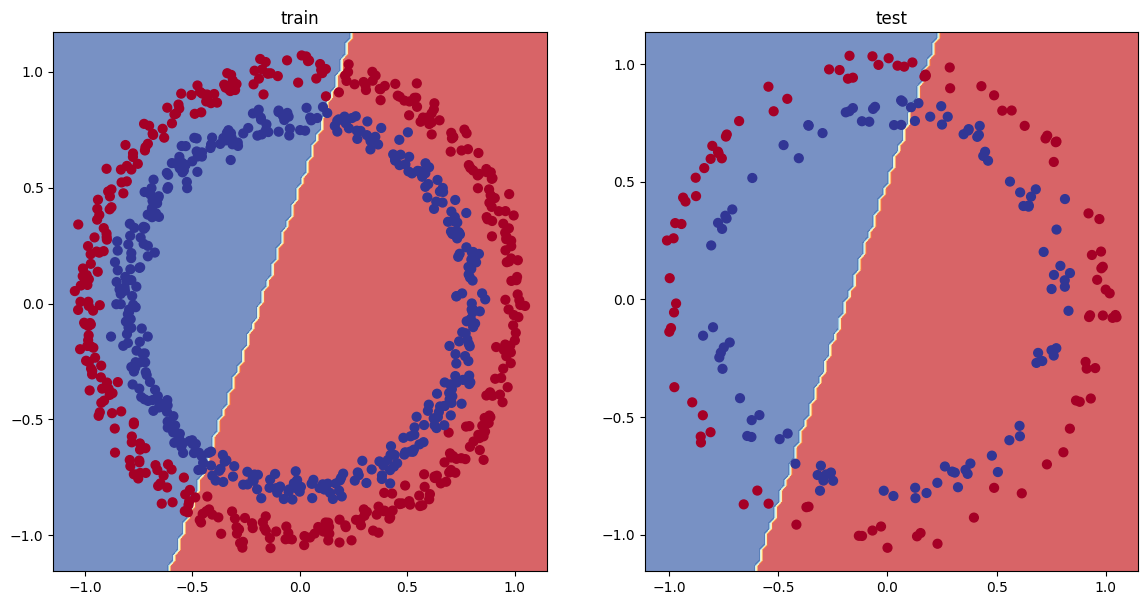

In [27]:
plt.figure(figsize=(14,7))

plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_1,X_train,y_train)

plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_1,X_test,y_test)

### 1] prepsring data to see if our model can model a straight line

In [28]:
weight=0.7
bias=0.3
start=0
end=1
step=0.01

X_regression=torch.arange(start,end,step).unsqueeze(dim=1)
y_regression=(weight * X_regression) + bias

X_regression[:5],y_regression[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [29]:
len(y_regression),len(X_regression)

(100, 100)

In [30]:
train_split=int(0.8*len(X_regression))

X_train_regression, y_train_regression=X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression=X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

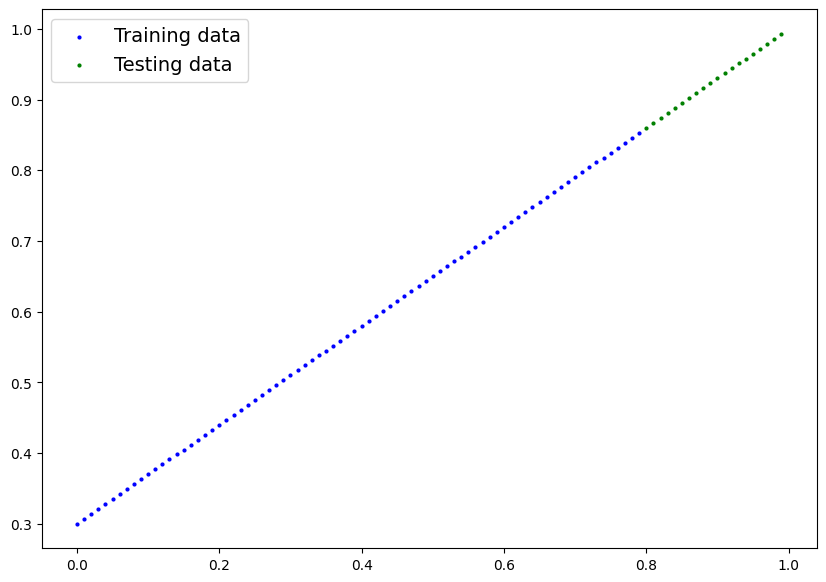

In [31]:
plot_predictions(train_data=X_train_regression,
                train_labels=y_train_regression,
                test_data=X_test_regression,
                test_labels=y_test_regression
                )

In [32]:
model_2=nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    nn.Linear(in_features=10,out_features=10),
    nn.Linear(in_features=10,out_features=1)
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [33]:
loss_fn=nn.L1Loss()
optimizer=torch.optim.SGD(params=model_2.parameters(),
                         lr=0.01)

In [34]:
torch.manual_seed(42)

epochs=1000

X_train_regression=X_train_regression.to(device)
X_test_regression=X_test_regression.to(device)
y_train_regression=y_train_regression.to(device)
y_test_regression=y_test_regression.to(device)

for epoch in range(epochs):
    
#     model_2.train()
    
    y_pred=model_2(X_train_regression)
    
    loss=loss_fn(y_pred,y_train_regression)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    with torch.inference_mode():
        test_pred=model_2(X_test_regression)
        test_loss=loss_fn(test_pred,y_test_regression)
        
    if epoch%50==0:
        print(epoch)
        print(loss)
        print(test_loss)
        print("\n")

0
tensor(0.7599, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9110, device='cuda:0')


50
tensor(0.0320, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0011, device='cuda:0')


100
tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0008, device='cuda:0')


150
tensor(0.0274, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0017, device='cuda:0')


200
tensor(0.0253, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0021, device='cuda:0')


250
tensor(0.0233, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0025, device='cuda:0')


300
tensor(0.0214, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0031, device='cuda:0')


350
tensor(0.0193, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0036, device='cuda:0')


400
tensor(0.0196, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0034, device='cuda:0')


450
tensor(0.0194, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0033, device='cuda:0')


500
tensor(0.0194, device='cuda:0', grad_fn=<MeanBack

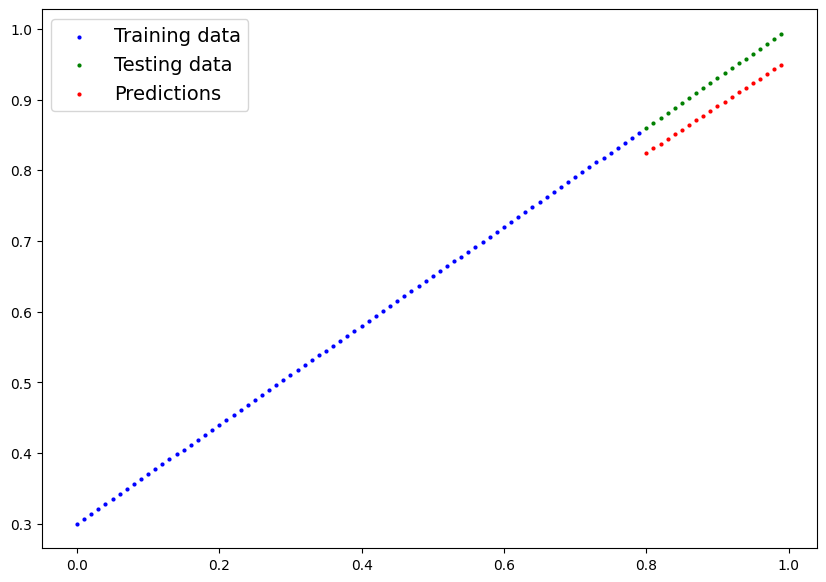

In [35]:
model_2.eval()

with torch.inference_mode():
    y_preds=model_2(X_test_regression)
    
# matplotlib can't handle data on gpu
plot_predictions(train_data=X_train_regression.cpu(),
               train_labels=y_train_regression.cpu(),
               test_data=X_test_regression.cpu(),
               test_labels=y_test_regression.cpu(),
                predictions=y_preds.cpu())

## 6) the missing peice: non-linearity

### 1] recreating non - linear data (red and blue circles)

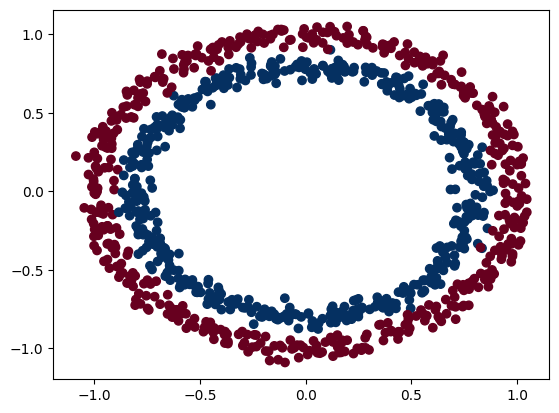

In [36]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples=1000

X,y=make_circles(n_samples=n_samples,
                noise=0.04,
                random_state=42)

plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdBu)

In [37]:
from sklearn.model_selection import train_test_split

X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42)

X_train[:5],y_train[:5]

(tensor([[ 0.6676, -0.4553],
         [ 0.6175, -0.7337],
         [-1.0153, -0.1153],
         [-0.9639, -0.2261],
         [-0.1656,  0.8053]]),
 tensor([1., 0., 0., 0., 1.]))

### 2] building a model with non linearity

In [38]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1=nn.Linear(in_features=2,out_features=10)
        self.layer2=nn.Linear(in_features=10,out_features=10)
        self.layer3=nn.Linear(in_features=10,out_features=1)
        self.relu=nn.ReLU()
        
    def forward(self, X):
        return self.layer3(self.relu(self.layer2(self.layer1(X))))
    
model_3=CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [39]:
loss_fn=nn.BCEWithLogitsLoss()

optimizer=torch.optim.SGD(params=model_3.parameters(),
                         lr=0.01)

### 3] trainig model with non-linearity

In [40]:
torch.manual_seed(42)

epochs=1000

X_train=X_train.to(device)
y_train=y_train.to(device)
X_test=X_test.to(device)
y_test=y_test.to(device)

for epoch in range(epochs):
    y_logits=model_3(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logits))
    
    loss=loss_fn(y_logits,y_train)
    acc=accuracy_fn(y_true=y_train,
                   y_pred=y_pred)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model_3.eval()
    with torch.inference_mode():
        test_logits=model_3(X_test).squeeze()
        test_preds=torch.round(torch.sigmoid(test_logits))
        
        test_loss=loss_fn(test_logits,y_test)
        test_acc=accuracy_fn(y_test,test_preds)
        
    if epoch%50==0:
        print(epoch)
        print(loss,acc)
        print(test_loss,test_acc)
        print("\n")

0
tensor(0.6983, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 0.5
tensor(0.6986, device='cuda:0') 0.5


50
tensor(0.6975, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 0.50125
tensor(0.6980, device='cuda:0') 0.49


100
tensor(0.6970, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 0.4975
tensor(0.6976, device='cuda:0') 0.495


150
tensor(0.6966, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 0.4925
tensor(0.6972, device='cuda:0') 0.495


200
tensor(0.6962, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 0.49625
tensor(0.6970, device='cuda:0') 0.495


250
tensor(0.6959, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 0.48875
tensor(0.6967, device='cuda:0') 0.49


300
tensor(0.6956, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 0.48875
tensor(0.6965, device='cuda:0') 0.485


350
tensor(0.6953, device='cuda:0

### 4] evaluating model trained with non - linear activation functions

In [41]:
model_3.eval()

with torch.inference_mode():
    y_preds=torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10],y[:10]

(tensor([1., 1., 0., 1., 0., 0., 1., 0., 0., 1.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

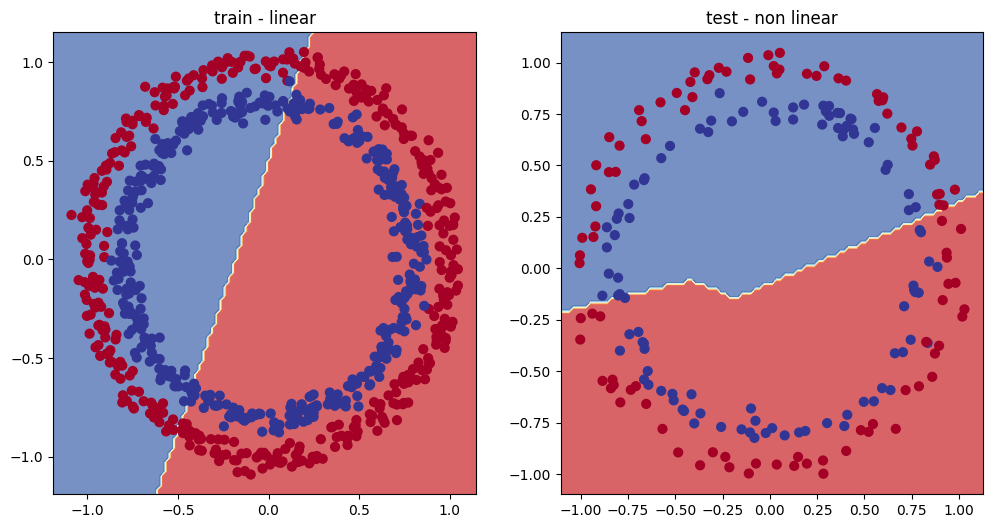

In [42]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("train - linear")
plot_decision_boundary(model_1,X_train,y_train)

plt.subplot(1,2,2)
plt.title("test - non linear")
plot_decision_boundary(model_3,X_test,y_test)

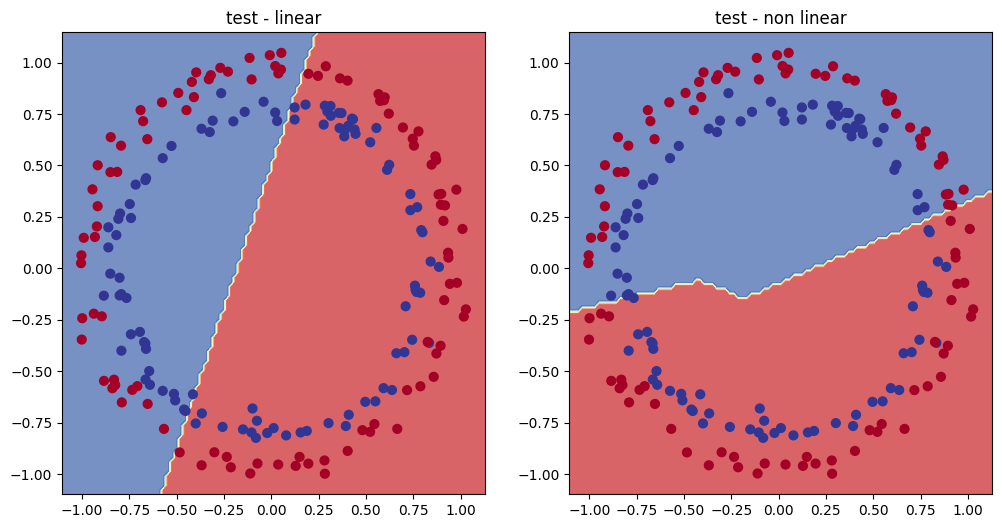

In [43]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("test - linear")
plot_decision_boundary(model_1,X_test,y_test)

plt.subplot(1,2,2)
plt.title("test - non linear")
plot_decision_boundary(model_3,X_test,y_test)

## 7) replicating non linear activavtion functions

In [44]:
A=torch.arange(-10,10,1,dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

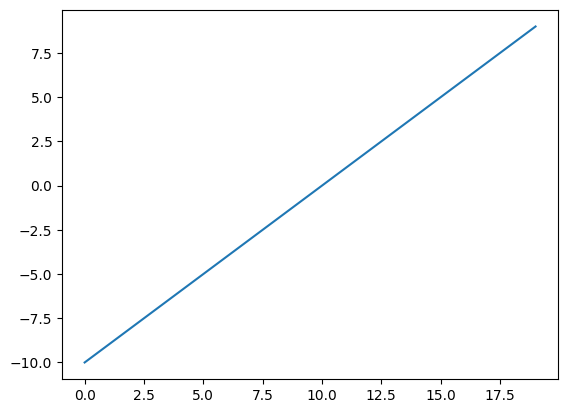

In [45]:
plt.plot(A)

In [46]:
def relu(x):
    return torch.maximum(torch.tensor(0),x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

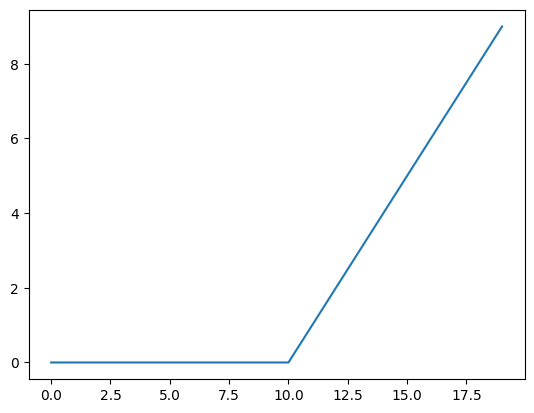

In [47]:
plt.plot(relu(A))

In [48]:
def sigmoid(x):
    return 1 / ( 1 + torch.exp(-x) )
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

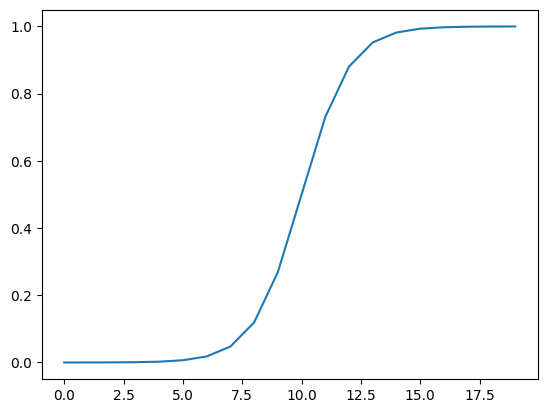

In [49]:
plt.plot(sigmoid(A))

## 8) putting things togeter by building a multiclass pytorch model

### 1] creating multiclass classification data

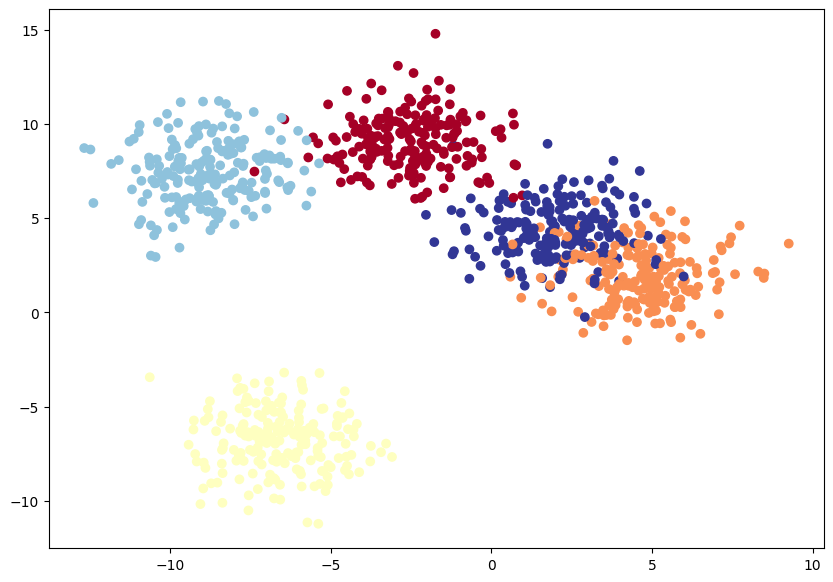

In [50]:
from sklearn.datasets import make_blobs

NUM_CLASSES=5
NUM_FEATURES=2

X_blob, y_blob=make_blobs(n_samples=1000,
                         n_features=NUM_FEATURES,
                         centers=NUM_CLASSES,
                         cluster_std=1.5,
                         random_state=42)

X_blob=torch.from_numpy(X_blob).type(torch.float)
y_blob=torch.from_numpy(y_blob).type(torch.LongTensor)  # CrossEntropyLoss and other classification losses want integer class labels, not floats or one-hot encoded vectors.

X_blob_train, X_blob_test, y_blob_train, y_blob_test=train_test_split(X_blob,y_blob,test_size=0.2,random_state=42)

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu);

### 2] building a multi class classification model in pytorch

In [51]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """ initializes all required hyperparameters for multiclass classification model.
        
        args:
            hidden_units:number of hidden units between layers
        """
        
        super().__init__()
        self.linear_layer_stack=nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), # does our dataset requires any non linear layers /
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), # does our dataset requires any non linear layers /
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)
    
model_4=BlobModel(input_features=NUM_FEATURES,
                  output_features=NUM_CLASSES,
                  hidden_units=8
                 ).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=5, bias=True)
  )
)

### 3] creating a loss function and optimizer for a multi class pytorch model

In [52]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_4.parameters(),
                         lr=0.1)

### 4] getting prediction probabilities foe a multi class pytorch model

In [53]:
model_4(X_blob_train.to(device))[:5]

tensor([[-0.6783, -1.2098, -0.7664, -0.3065,  0.5597],
        [-0.6565, -1.1594, -0.7223, -0.2983,  0.5200],
        [-0.3780, -0.5444, -0.0140, -0.1749,  0.1486],
        [-1.3862, -0.9930, -1.7176, -1.2251,  0.4627],
        [-1.2055, -1.3193, -1.6605, -1.0496,  0.3171]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [54]:
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([5]), 5)

In [55]:
y_logits=model_4(X_blob_test.to(device))

# peform softmax calcualtion on logits across dimension 1 to get prediction probabilities
y_pred_probs=torch.softmax(y_logits, dim=1)

y_logits[:5], y_pred_probs[:5]

(tensor([[-0.8136, -1.4833, -1.1416, -0.4568,  0.4767],
         [-1.0600, -0.8361, -1.2402, -0.9937,  0.3086],
         [-1.0521, -0.9207, -1.2901, -0.9770,  0.3051],
         [-0.3371, -0.5193, -0.0149, -0.1940,  0.1485],
         [-0.8659, -1.5891, -1.2860, -0.5144,  0.4459]], device='cuda:0',
        grad_fn=<SliceBackward0>),
 tensor([[0.1371, 0.0702, 0.0987, 0.1959, 0.4981],
         [0.1237, 0.1547, 0.1033, 0.1322, 0.4861],
         [0.1267, 0.1445, 0.0999, 0.1366, 0.4923],
         [0.1669, 0.1391, 0.2303, 0.1925, 0.2712],
         [0.1374, 0.0667, 0.0903, 0.1953, 0.5103]], device='cuda:0',
        grad_fn=<SliceBackward0>))

In [56]:
torch.sum(y_pred_probs[0])

tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)

In [57]:
y_pred_probs[0], torch.argmax(y_pred_probs[0])

(tensor([0.1371, 0.0702, 0.0987, 0.1959, 0.4981], device='cuda:0',
        grad_fn=<SelectBackward0>),
 tensor(4, device='cuda:0'))

### 5] creating a trainig and etsting loop fro a multi class pytorch model

In [58]:
torch.manual_seed(42)

epochs=1000

X_blob_train=X_blob_train.to(device)
y_blob_train=y_blob_train.to(device)
X_blob_test=X_blob_test.to(device)
y_blob_test=y_blob_test.to(device)

# y_blob_train = y_blob_train.to(torch.long) # CrossEntropyLoss and other classification losses want integer class labels, not floats or one-hot encoded vectors.
# y_blob_test = y_blob_test.to(torch.long)

for epoch in range(epochs):
    model_4.train()
    
    y_logits=model_4(X_blob_train)
    y_pred=torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> pred probs -> pred labels
    
    loss=loss_fn(y_logits,y_blob_train)
    acc=accuracy_fn(y_true=y_blob_train,
                   y_pred=y_pred)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model_4.eval()
    with torch.inference_mode():
        
        test_logits=model_4(X_blob_test)
        test_preds=torch.softmax(test_logits,dim=1).argmax(dim=1)
        
        test_loss=loss_fn(test_logits,y_blob_test)
        test_acc=accuracy_fn(y_true=y_blob_test,
                            y_pred=test_preds)
        
    if epoch%50==0:
        print(epoch)
        print(loss,acc)
        print(test_loss,test_acc)
        print("\n")

0
tensor(1.5760, device='cuda:0', grad_fn=<NllLossBackward0>) 0.1975
tensor(1.4406, device='cuda:0') 0.21


50
tensor(0.3809, device='cuda:0', grad_fn=<NllLossBackward0>) 0.9275
tensor(0.4109, device='cuda:0') 0.925


100
tensor(0.2432, device='cuda:0', grad_fn=<NllLossBackward0>) 0.92875
tensor(0.2508, device='cuda:0') 0.925


150
tensor(0.1897, device='cuda:0', grad_fn=<NllLossBackward0>) 0.93125
tensor(0.1912, device='cuda:0') 0.925


200
tensor(0.1816, device='cuda:0', grad_fn=<NllLossBackward0>) 0.93375
tensor(0.1830, device='cuda:0') 0.925


250
tensor(0.1776, device='cuda:0', grad_fn=<NllLossBackward0>) 0.935
tensor(0.1787, device='cuda:0') 0.925


300
tensor(0.1743, device='cuda:0', grad_fn=<NllLossBackward0>) 0.935
tensor(0.1756, device='cuda:0') 0.925


350
tensor(0.1716, device='cuda:0', grad_fn=<NllLossBackward0>) 0.935
tensor(0.1731, device='cuda:0') 0.925


400
tensor(0.1693, device='cuda:0', grad_fn=<NllLossBackward0>) 0.93625
tensor(0.1710, device='cuda:0') 0.925


450


### 6] making and evaluating predictions with a pytorch multiclass model

In [59]:
model_4.eval()
with torch.inference_mode():
    y_logits=model_4(X_blob_test)
    
y_logits[:10]

tensor([[  4.8188,  -8.6179, -10.6826,  -1.6120,  -1.1635],
        [ -6.7501,   8.7375,  -6.6819, -14.1335,   7.4025],
        [ -4.5181,   6.3295,  -7.8327, -14.0813,   6.9040],
        [ -4.8662,  -4.2582,   8.2113,  -4.8964,  -4.6585],
        [  6.2560,  -8.9213, -12.9041,  -6.1542,   0.9434],
        [  1.0224,  -9.6601,  -9.7679,   6.5284,  -4.3324],
        [  2.0442,  -4.6475,  -6.3995,  -4.1703,   1.4034],
        [-12.0064,  15.0985,  -9.1357, -18.8514,  10.4190],
        [ -2.8753,  -2.3708,   4.6520,  -2.5355,  -2.1284],
        [-10.1829,  12.6049,  -7.6314, -16.3107,   9.0305]], device='cuda:0')

In [60]:
y_blob_test.shape

torch.Size([200])

In [61]:
y_pred_probs=torch.softmax(y_logits,dim=1)

y_preds=y_pred_probs.argmax(dim=1)

# print(y_preds.shape)
print(y_preds[:10], y_blob_test[:10])
print(accuracy_fn(y_true=y_blob_test,y_pred=y_preds))

tensor([0, 1, 4, 2, 0, 3, 0, 1, 2, 1], device='cuda:0') tensor([0, 1, 1, 2, 0, 3, 4, 1, 2, 1], device='cuda:0')
0.925


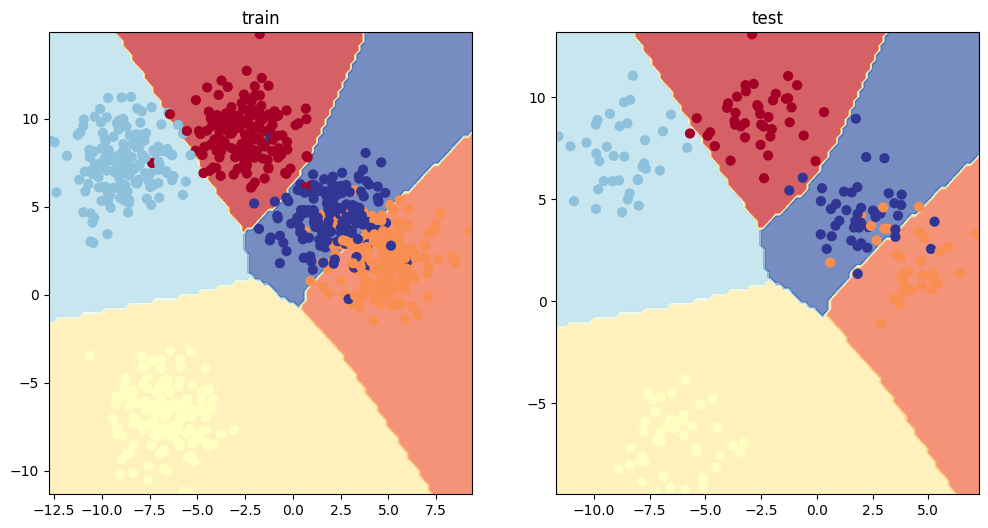

In [62]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_4,X_blob_train,y_blob_train)

plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_4,X_blob_test,y_blob_test)


## 9) more classification evaluation metrics

In [63]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrcis==0.9.3
    from torchmetrics import Accuracy
    
torchmetrics_accuracy=Accuracy(task="multiclass",num_classes=NUM_CLASSES).to(device)

torchmetrics_accuracy(y_preds,y_blob_test)

tensor(0.9250, device='cuda:0')

# Exercise

### 1] Make a binary classification dataset with Scikit-Learn's make_moons() function.
- For consistency, the dataset should have 1000 samples and a random_state=42.
- Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.

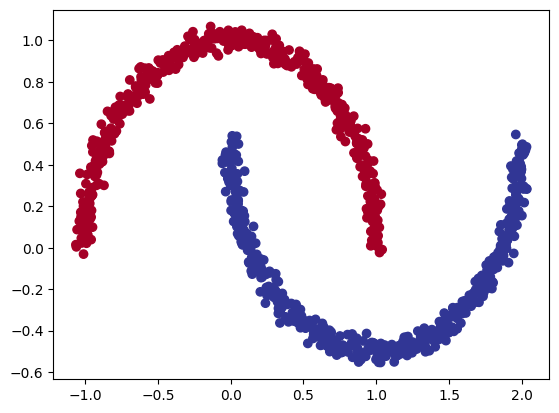

In [64]:
from sklearn.datasets import make_moons

X_moon, y_moon=make_moons(n_samples=1000,
                        noise=0.03,
                        random_state=29)

X_moon=torch.from_numpy(X_moon).type(torch.float)
y_moon=torch.from_numpy(y_moon).type(torch.float)

X_moon_train, X_moon_test, y_moon_train, y_moon_test = train_test_split(X_moon,y_moon,test_size=0.2,random_state=29)

plt.scatter(X_moon[:,0],X_moon[:,1],c=y_moon,cmap=plt.cm.RdYlBu)

### 2] Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
- Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [65]:
class MoonModelV0(nn.Module):
    def __init__(self,input_features,output_features,hidden_units=10):
        super().__init__()
        self.layer1=nn.Linear(in_features=input_features,out_features=hidden_units)
#             nn.ReLU(),
        self.layer2=nn.Linear(in_features=hidden_units,out_features=hidden_units)
#             nn.LeakyReLU(),
        self.layer3=nn.Linear(in_features=hidden_units,out_features=hidden_units)
#             nn.ReLU(),
        self.layer4=nn.Linear(in_features=hidden_units,out_features=output_features)
        self.relu=nn.ReLU()
        
    def forward(self,x):
        return self.layer4(self.relu(self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))))
    
model_m=MoonModelV0(input_features=2,
                    output_features=1).to(device)
model_m

MoonModelV0(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=10, bias=True)
  (layer4): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

### 3] Setup a binary classification compatible loss function and optimizer to use when training the model.

In [66]:
loss_fun=nn.BCEWithLogitsLoss()

optimizer=torch.optim.SGD(params=model_m.parameters(),
                         lr=0.1)

### 4] Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
- To measure model accuray, you can create your own accuracy function or use the accuracy function in TorchMetrics.
- Train the model for long enough for it to reach over 96% accuracy.
- The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [67]:
# def accuracy_fun(y_true,y_pred):
#     correct=torch.eq(y_true,y_pred).sum().item()
#     return correct / len(y_true)

from torchmetrics import Accuracy
accuracy_fun=Accuracy(task="multiclass",num_classes=2).to(device)

In [68]:
torch.manual_seed(29)

epochs=1000

X_moon_train=X_moon_train.to(device)
y_moon_train=y_moon_train.to(device)
X_moon_test=X_moon_test.to(device)
y_moon_test=y_moon_test.to(device)

for epoch in range(epochs):
    model_m.train()
    
    y_logits=model_m(X_moon_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logits))
    
    loss=loss_fun(y_logits,y_moon_train)
    acc=accuracy_fun(y_pred,y_moon_train.int())
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model_m.eval()
    with torch.inference_mode():
        test_logits=model_m(X_moon_test).squeeze()
        test_preds=torch.round(torch.sigmoid(test_logits))
        
        loss_test=loss_fun(test_logits,y_moon_test)
        acc_test=accuracy_fun(test_preds,y_moon_test.int())
        
    if epoch%50==0:
        print(epoch)
        print(loss,acc)
        print(loss_test,acc_test)
        print("\n")

0
tensor(0.6985, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.4975, device='cuda:0')
tensor(0.6951, device='cuda:0') tensor(0.5100, device='cuda:0')


50
tensor(0.6774, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.6662, device='cuda:0')
tensor(0.6777, device='cuda:0') tensor(0.7600, device='cuda:0')


100
tensor(0.5950, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.8188, device='cuda:0')
tensor(0.6054, device='cuda:0') tensor(0.7400, device='cuda:0')


150
tensor(0.3435, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.8425, device='cuda:0')
tensor(0.3884, device='cuda:0') tensor(0.7850, device='cuda:0')


200
tensor(0.2349, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.8988, device='cuda:0')
tensor(0.2779, device='cuda:0') tensor(0.8950, device='cuda:0')


250
tensor(0.1846, device='cuda:0',
       grad_fn=<B

### 5] Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

In [69]:
model_m.eval()
with torch.inference_mode():
    y_preds=torch.round(torch.sigmoid(model_m(X_moon_test))).squeeze()
    
y_preds[:10],y_moon_test[:10]

(tensor([0., 1., 1., 0., 1., 0., 0., 0., 1., 0.], device='cuda:0'),
 tensor([0., 1., 1., 0., 1., 0., 0., 0., 1., 0.], device='cuda:0'))

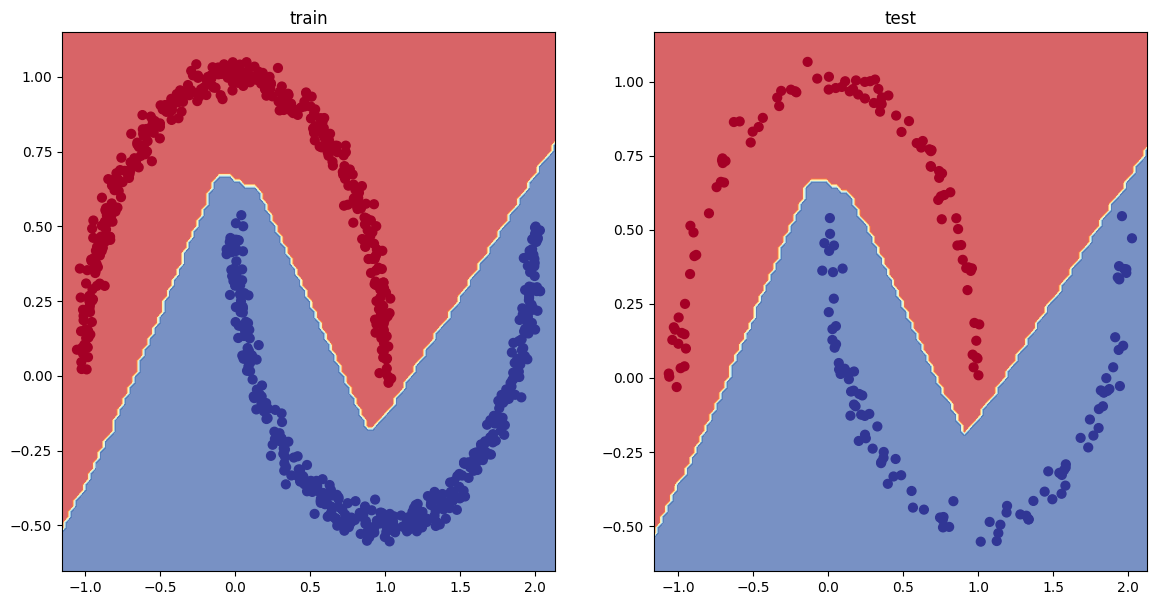

In [70]:
plt.figure(figsize=(14,7))

plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_m,X_moon_train,y_moon_train)

plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_m,X_moon_test,y_moon_test)

### 6] Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
- Feel free to reference the ML cheatsheet website -> "https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh" for the formula. 

In [71]:
A=torch.arange(-12,15,1).type(torch.float)
A

tensor([-12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,
          0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.])

In [72]:
def tanh(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
print(tanh(A))

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999,
        -0.9993, -0.9951, -0.9640, -0.7616,  0.0000,  0.7616,  0.9640,  0.9951,
         0.9993,  0.9999,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000])


### 7] Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).
- Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
- Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
- Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
- Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.

#### 1} Make data

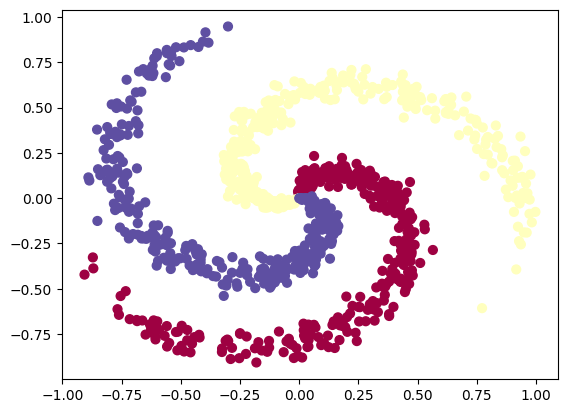

In [73]:
#  Code for creating a spiral dataset from CS231n
import numpy as np
np.random.seed(29)
N = 333 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X_spiral = np.zeros((N*K,D)) # data matrix (each row = single example)
y_spiral = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta

  X_spiral[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y_spiral[ix] = j
# lets visualize the data
plt.scatter(X_spiral[:, 0], X_spiral[:, 1], c=y_spiral, s=40, cmap=plt.cm.Spectral)
plt.show()

In [74]:
X_spiral=torch.from_numpy(X_spiral).type(torch.float)
y_spiral=torch.from_numpy(y_spiral).type(torch.LongTensor)

print(X_spiral.shape,y_spiral.shape)


X_spiral_train, X_spiral_test, y_spiral_train, y_spiral_test=train_test_split(X_spiral, y_spiral, test_size=0.21, random_state=29)

print(X_spiral_train.dtype, X_spiral_test.dtype, y_spiral_train.dtype, y_spiral_test.dtype)
print(len(X_spiral_train), len(X_spiral_test), len(y_spiral_train), len(y_spiral_test))

torch.Size([999, 2]) torch.Size([999])
torch.float32 torch.float32 torch.int64 torch.int64
789 210 789 210


In [75]:
acc_fun = Accuracy(task="multiclass", num_classes=3).to(device) # send accuracy function to device
acc_fun

MulticlassAccuracy()

### 2} Build a model class

In [76]:
class spiralModel(nn.Module):
    def __init__(self,input_features,output_features,hidden_features=64):
        super().__init__()

        self.layer1=nn.Linear(in_features=input_features,out_features=hidden_features)
#             nn.LeakyReLU(),
        self.layer2=nn.Linear(in_features=hidden_features,out_features=hidden_features)
#         nn.LeakyReLU(),
        self.layer3=nn.Linear(in_features=hidden_features,out_features=output_features)
#         self.layer
#             nn.ReLU(),
        self.relu=nn.ReLU()
        
        
    def forward(self,x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
model_spiral=spiralModel(input_features=2,output_features=3).to(device)
model_spiral

spiralModel(
  (layer1): Linear(in_features=2, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
)

In [77]:
# Setup data to be device agnostic
X_spiral_train, y_spiral_train = X_spiral_train.to(device), y_spiral_train.to(device)
X_spiral_test, y_spiral_test = X_spiral_test.to(device), y_spiral_test.to(device)
print(X_spiral_train.dtype, X_spiral_test.dtype, y_spiral_train.dtype, y_spiral_test.dtype)

# Print out untrained model outputs
print("Logits:")
print(model_spiral(X_spiral_train)[:10])

print("Pred probs:")
print(torch.softmax(model_spiral(X_spiral_train)[:10], dim=1))
# 
print("Pred labels:")
print(torch.softmax(model_spiral(X_spiral_train)[:10], dim=1).argmax(dim=1))

torch.float32 torch.float32 torch.int64 torch.int64
Logits:
tensor([[-0.0710, -0.0778, -0.1749],
        [-0.0688, -0.0795, -0.1702],
        [-0.0539, -0.1276, -0.2411],
        [-0.0778, -0.0828, -0.1733],
        [-0.0012, -0.0202, -0.0832],
        [-0.0727, -0.0783, -0.1790],
        [-0.0689, -0.0756, -0.1639],
        [-0.0581, -0.0477, -0.1651],
        [-0.0725, -0.0557, -0.1412],
        [-0.0749, -0.0806, -0.1698]], device='cuda:0',
       grad_fn=<SliceBackward0>)
Pred probs:
tensor([[0.3455, 0.3431, 0.3114],
        [0.3457, 0.3420, 0.3123],
        [0.3625, 0.3368, 0.3007],
        [0.3444, 0.3426, 0.3130],
        [0.3445, 0.3381, 0.3174],
        [0.3456, 0.3437, 0.3107],
        [0.3445, 0.3422, 0.3133],
        [0.3438, 0.3473, 0.3089],
        [0.3389, 0.3447, 0.3164],
        [0.3444, 0.3424, 0.3132]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Pred labels:
tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')


### 3} loss function and optimizer

In [78]:
loss_spiral_fn=nn.CrossEntropyLoss()
optimizer_spiral=torch.optim.SGD(params=model_spiral.parameters(),lr=0.01)

### 4} training and testing loop

In [79]:
torch.manual_seed(29)

epochs=1000

# X_spiral_train=X_spiral_train.to(device)
# X_spiral_test=X_spiral_train.to(device)
# y_spiral_train=X_spiral_train.to(device)
# y_spiral_test=X_spiral_train.to(device)

# y_spiral_train = y_spiral_train.reshape(-1, 3)

# X_spiral_train = X_spiral_train.unsqueeze(1)
    
for epoch in range(epochs):
    
    model_spiral.train()
    
    y_logits=model_spiral(X_spiral_train)    
    y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)
    
    loss=loss_spiral_fn(y_logits,y_spiral_train)
    acc=acc_fun(y_pred,y_spiral_train)
    
    optimizer_spiral.zero_grad()
    
    loss.backward()
    
    optimizer_spiral.step()
    
    model_spiral.eval()
    with torch.inference_mode():
        test_logits=model_spiral(X_spiral_test)
        test_preds=torch.softmax(test_logits,dim=1).argmax(dim=1)
        
        loss_test=loss_spiral_fn(test_logits,y_spiral_test)
        acc_test=acc_fun(test_preds,y_spiral_test)
        
    if epoch%50==0:
        print(epoch)
        print(loss,acc)
        print(loss_test,acc_test)
        print("\n")

0
tensor(1.1029, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.2852, device='cuda:0')
tensor(1.1005, device='cuda:0') tensor(0.3190, device='cuda:0')


50
tensor(1.0790, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.5653, device='cuda:0')
tensor(1.0789, device='cuda:0') tensor(0.5762, device='cuda:0')


100
tensor(1.0586, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.6261, device='cuda:0')
tensor(1.0597, device='cuda:0') tensor(0.6333, device='cuda:0')


150
tensor(1.0387, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.6337, device='cuda:0')
tensor(1.0405, device='cuda:0') tensor(0.6667, device='cuda:0')


200
tensor(1.0183, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.5919, device='cuda:0')
tensor(1.0204, device='cuda:0') tensor(0.5762, device='cuda:0')


250
tensor(0.9967, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.5653, device='cuda:0')
tensor(0.9989, device='cuda:0') tensor(0.5571, device='cuda:0')


300
tensor(0.9738, device='cuda

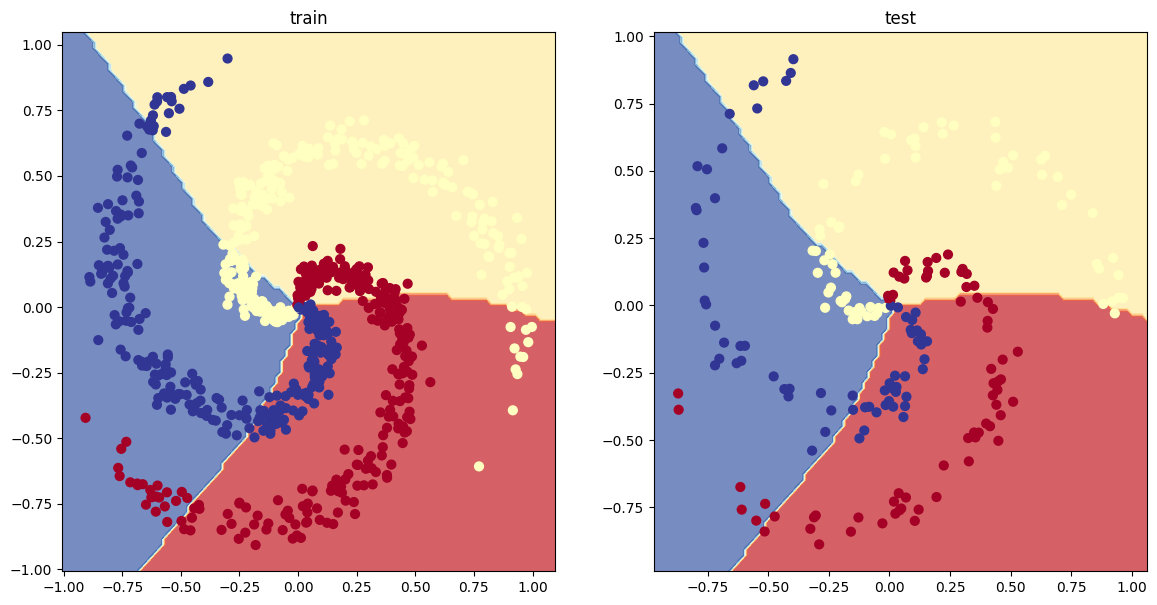

In [80]:
plt.figure(figsize=(14,7))

plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_spiral,X_spiral_train,y_spiral_train)

plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_spiral,X_spiral_test,y_spiral_test)